In [1]:
from preprocessing import *
from crf import *
import os

ROOT_DIR = os.path.dirname(os.path.abspath(""))

train_data_tokens = load_tokens(os.path.join(ROOT_DIR, "data", "training_data_tokens.json"))
train_data = json.load(open(os.path.join(ROOT_DIR, "data", "training_data.json"), "r"))

/home/eric/miniconda3/envs/nlp/lib/python3.11/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
train_data_bio = create_bio_tags(train_data, train_data_tokens)
with open(os.path.join(ROOT_DIR, "data", "training_data_bio.json"), "w") as f:
	json.dump(train_data_bio, f)

In [4]:
model = CRF(
	model_path=os.path.join(ROOT_DIR, "models", "crf_0_0.crfsuite"),
	trainer_params={
		"c1": 1e-3,
		"c2": 1e-1,
		"max_iterations": 50,
		"padding": True,
		"before_lim": 6,
		"after_lim": 1,
	},
	verbose=False
)

In [4]:
precompute_pos(
	tokens_path=os.path.join(ROOT_DIR, "data", "training_data_tokens.json"),
	pos_path=os.path.join(ROOT_DIR, "data", "training_data_pos.json")
)

100%|██████████| 254/254 [00:31<00:00,  8.16it/s]


In [5]:
model.train(
	train_tokens_path=os.path.join(ROOT_DIR, "data", "training_data_tokens.json"),
	train_labels_path=os.path.join(ROOT_DIR, "data", "training_data_bio.json"),
	train_pos_path=os.path.join(ROOT_DIR, "data", "training_data_pos.json"),
)

100%|██████████| 254/254 [00:00<00:00, 3208.50it/s]


Training model...
Model trained


In [7]:
model.process(
	data_path=os.path.join(ROOT_DIR, "data", "training_data.json"),
	tokens_path=os.path.join(ROOT_DIR, "data", "training_data_tokens.json"),
	save_path=os.path.join(ROOT_DIR, "data", "training_data_predictions_crf.json"),
	pos_path=os.path.join(ROOT_DIR, "data", "training_data_pos.json"),
)

100%|██████████| 254/254 [00:03<00:00, 79.58it/s]


In [8]:
from eval import EvalOfficial

with open(os.path.join(ROOT_DIR, "data", "training_data.json"), "r", encoding="utf8") as _f:
	train_data = json.load(_f)

with open(os.path.join(ROOT_DIR, "data", "training_data_predictions_crf.json"), "r", encoding="utf8") as _f:
	train_data_predictions = json.load(_f)

metric = EvalOfficial()
p, r, f1 = metric.calc(train_data_predictions, train_data)
print("Training")
print(f"Precision: {p}, Recall:{r}, F1:{f1}")

Training
Precision: 0.9797242276351673, Recall:0.9797242276351673, F1:0.9797242276351673


### Experimentation

In [1]:
from eval import *
from preprocessing import *
import os

ROOT_DIR = os.path.dirname(os.path.abspath(""))

In [2]:
# split data into training and validation
val_frac = 0.2
with open(os.path.join(ROOT_DIR, "data", "training_data.json"), "r", encoding="utf8") as _f:
	train_data = json.load(_f)

val_docs = int(val_frac * len(train_data))
val_data = train_data[:val_docs]
with open(os.path.join(ROOT_DIR, "data", "val_set_data.json"), "w", encoding="utf8") as _f:
	json.dump(val_data, _f)
new_train_data = train_data[val_docs:]
with open(os.path.join(ROOT_DIR, "data", "train_set_data.json"), "w", encoding="utf8") as _f:
	json.dump(new_train_data, _f)

In [3]:
eval = EvalCRF(
	save_dir=os.path.join(ROOT_DIR, "temp"),
	results_dir=os.path.join(ROOT_DIR, "data"),
	train_data_path=os.path.join(ROOT_DIR, "data", "train_set_data.json"),
	eval_data_path=os.path.join(ROOT_DIR, "data", "val_set_data.json"),
	lemmatize=False,
	remove_punctuation=True,
	replace_numbers=None,
	verbose=True
)

Creating evaluation tokens...


100%|██████████| 50/50 [00:00<00:00, 65.83it/s]


Creating training tokens...


100%|██████████| 204/204 [00:02<00:00, 69.98it/s]


Precomputing training POS tags...


100%|██████████| 204/204 [00:50<00:00,  4.06it/s]


Precomputing evaluation POS tags...


100%|██████████| 50/50 [00:14<00:00,  3.47it/s]


Loading NLP models...


In [4]:
trainer_params={
		"c1": 1e-3,
		"c2": 1e-1,
		"max_iterations": 50,
		"padding": True,
		"before_lim": 6,
		"after_lim": 1,
	}
eval.evaluate(**trainer_params)

Instantiating CRF...
Training CRF...


100%|██████████| 204/204 [00:00<00:00, 3527.01it/s]


Training model...
Model trained
Predicting...


100%|██████████| 50/50 [00:00<00:00, 63.75it/s]


Calculating metrics...


{'precision': 0.9649136248528155,
 'recall': 0.9649136248528155,
 'f1': 0.9649136248528155,
 'time': 0.8872}

In [5]:
eval = EvalCRF(
	save_dir=os.path.join(ROOT_DIR, "temp"),
	results_dir=os.path.join(ROOT_DIR, "data"),
	train_data_path=os.path.join(ROOT_DIR, "data", 'train_set_data.json'),
	eval_data_path=os.path.join(ROOT_DIR, "data", 'val_set_data.json'),
	load_existing_train_tokens=True,
	load_existing_eval_tokens=True,
	load_existing_train_pos=True,
	load_existing_eval_pos=True,
	lemmatize=False,
	remove_punctuation=True,
	replace_numbers=None,
	verbose=False
)

In [6]:
combinations = eval.grid_search(
	{
		"c1": [1e-2, 1e-3, 1e-4],
		"c2": [1e-0, 1e-1, 1e-2],
		"max_iterations": [50],
		"padding": [True],
		"before_lim": [6],
		"after_lim": [1],
	}
)

Progress: 9/9


In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data = []
for combo in combinations:
    params = combo['params']
    metrics = combo['metrics']
    data.append((params['c1'], params['c2'], metrics['f1']))
df = pd.DataFrame(data, columns=['c1', 'c2', 'f1'])
df.sort_values(by=['c1', 'c2'], inplace=True)

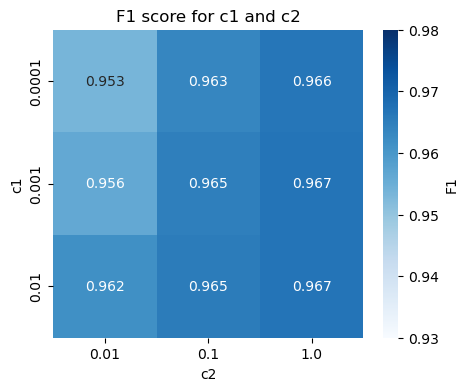

In [8]:
pivot_table = df.pivot_table(index="c1", columns="c2", values="f1")

plt.figure(figsize=(5, 4))
sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap='Blues', cbar_kws={'label': 'F1'}, vmin=0.93, vmax=0.98)

plt.title('F1 score for c1 and c2')
plt.ylabel('c1')
plt.xlabel('c2')
plt.show()

In [9]:
combinations2 = eval.grid_search(
	{
		"c1": [1e-2],
		"c2": [1e-0],
		"max_iterations": [50],
		"padding": [True, False],
		"before_lim": [6, 3],
		"after_lim": [1, 2],
	}
)

Progress: 8/8


In [10]:
data = []
for combo in combinations2:
    params = combo['params']
    metrics = combo['metrics']
    data.append((params['padding'], params['before_lim'], params['after_lim'], metrics['f1']))
df = pd.DataFrame(data, columns=['padding', 'before_lim', 'after_lim', 'f1'])
df.sort_values(by=['padding', 'before_lim', 'after_lim'], inplace=True)

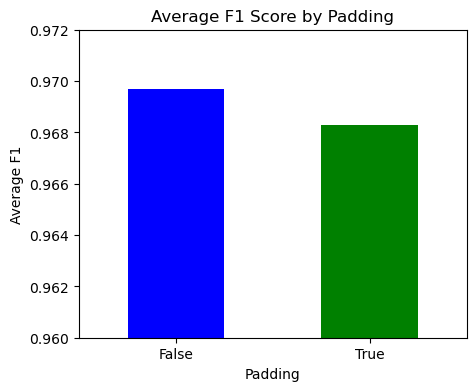

In [15]:
average_f1 = df.groupby('padding')['f1'].mean()
plt.figure(figsize=(5, 4))
average_f1.plot(kind='bar', color=['blue', 'green'])
plt.title('Average F1 Score by Padding')
plt.xlabel('Padding')
plt.ylabel('Average F1')
plt.xticks(rotation=0)
plt.ylim(0.96, 0.972)
plt.show()

In [31]:
combinations3 = eval.grid_search(
	{
		"c1": [1e-2],
		"c2": [1e-0],
		"max_iterations": [50],
		"padding": [False],
		"before_lim": [10, 8, 6, 4, 2],
		"after_lim": [1],
	}
)

Progress: 5/5


In [32]:
combinations4 = eval.grid_search(
	{
		"c1": [1e-2],
		"c2": [1e-0],
		"max_iterations": [50],
		"padding": [False],
		"before_lim": [6],
		"after_lim": [0, 1, 2, 3, 4],
	}
)

Progress: 5/5


In [36]:
data = []
for combo in combinations3:
    params = combo['params']
    metrics = combo['metrics']
    data.append((params['before_lim'], metrics['f1']))
df = pd.DataFrame(data, columns=['before_lim', 'f1'])
df.sort_values(by=['before_lim'], inplace=True)

In [37]:
data = []
for combo in combinations4:
    params = combo['params']
    metrics = combo['metrics']
    data.append((params['after_lim'], metrics['f1']))
df2 = pd.DataFrame(data, columns=['after_lim', 'f1'])
df2.sort_values(by=['after_lim'], inplace=True)

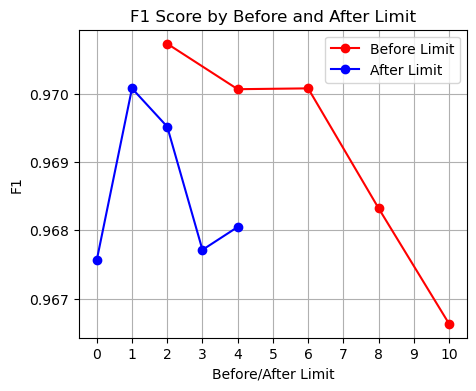

In [41]:
plt.figure(figsize=(5, 4))
plt.plot(df['before_lim'], df['f1'], marker='o', color='red')
plt.plot(df2['after_lim'], df2['f1'], marker='o', color='blue')
plt.title('F1 Score by Before and After Limit')
plt.xlabel('Before/After Limit')
plt.ylabel('F1')
plt.legend(['Before Limit', 'After Limit'])
plt.xticks(range(0, 11))
plt.grid()
plt.show()

### Testing

In [1]:
from eval import *
from preprocessing import *
import os

In [2]:
eval = EvalCRF(
	save_dir=os.path.join(ROOT_DIR, "temp"),
	results_dir=os.path.join(ROOT_DIR, "data"),
	train_data_path=os.path.join(ROOT_DIR, "data", "training_data.json"),
	eval_data_path=os.path.join(ROOT_DIR, "data", "test_data.json"),
	load_existing_train_tokens=True,
	load_existing_eval_tokens=True,
	load_existing_train_pos=True,
	load_existing_eval_pos=True,
	lemmatize=False,
	remove_punctuation=True,
	replace_numbers=None,
	verbose=True
)

Loading NLP models...


In [3]:
trainer_params={
		"c1": 1e-2,
		"c2": 1e-0,
		"max_iterations": 100,
		"padding": False,
		"before_lim": 6,
		"after_lim": 1,
	}
cv_results = eval.cross_validation(5, **trainer_params) # this only uses the training data

Instantiating CRF...
Training CRF...


100%|██████████| 204/204 [00:00<00:00, 2451.21it/s]


Training model...
Model trained
Predicting...


100%|██████████| 50/50 [00:00<00:00, 66.83it/s]


Calculating metrics...
Instantiating CRF...
Training CRF...


100%|██████████| 204/204 [00:00<00:00, 3509.13it/s]


Training model...
Model trained
Predicting...


100%|██████████| 50/50 [00:01<00:00, 43.76it/s]


Calculating metrics...
Instantiating CRF...
Training CRF...


100%|██████████| 204/204 [00:00<00:00, 2807.78it/s]


Training model...
Model trained
Predicting...


100%|██████████| 50/50 [00:00<00:00, 63.42it/s]


Calculating metrics...
Instantiating CRF...
Training CRF...


100%|██████████| 204/204 [00:00<00:00, 3318.12it/s]


Training model...
Model trained
Predicting...


100%|██████████| 50/50 [00:00<00:00, 77.48it/s]


Calculating metrics...
Instantiating CRF...
Training CRF...


100%|██████████| 200/200 [00:00<00:00, 2948.20it/s]


Training model...
Model trained
Predicting...


100%|██████████| 54/54 [00:00<00:00, 71.38it/s]


Calculating metrics...


In [7]:
print("F1 score:", cv_results["avg_f1"])
print("Inference time:", cv_results["avg_time"], "s")

F1 score: 0.9725630714777236
Inference time: 0.91342 s


In [11]:
trainer_params={
		"c1": 1e-2,
		"c2": 1e-0,
		"max_iterations": 100,
		"padding": False,
		"before_lim": 6,
		"after_lim": 1,
	}
eval.evaluate(**trainer_params) # now we use the test data

Instantiating CRF...
Training CRF...


100%|██████████| 254/254 [00:00<00:00, 3415.24it/s]


Training model...
Model trained
Predicting...


100%|██████████| 64/64 [00:01<00:00, 57.76it/s]


Calculating metrics...


{'precision': 0.9705290078028423,
 'recall': 0.9705290078028423,
 'f1': 0.9705290078028423,
 'time': 1.2396}

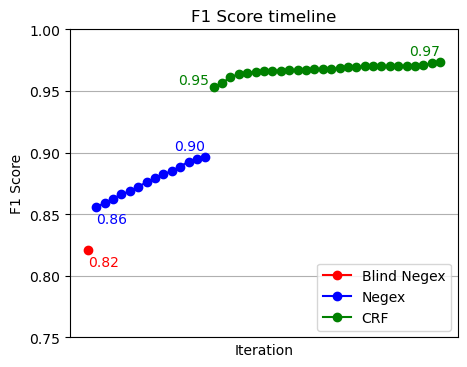

In [61]:
import matplotlib.pyplot as plt

with open(os.path.join(ROOT_DIR, "data", "results.json"), "r", encoding="utf8") as _f:
	all_results = json.load(_f)

blind_negex_f1 = sorted([result["metrics"]["f1"] for result in all_results["BlindNegex"]])
negex_f1 = sorted([result["metrics"]["f1"] for result in all_results["Negex"]])
crf_f1 = sorted([result["metrics"]["f1"] for result in all_results["CRF"]])

plt.figure(figsize=(5, 4))
plt.title("F1 Score timeline")
l1 = len(blind_negex_f1)
l2 = len(negex_f1)
l3 = len(crf_f1)
plt.plot(range(l1), blind_negex_f1, marker='o', color='red')
plt.plot(range(l1, l1+l2), negex_f1, marker='o', color='blue')
plt.plot(range(l1+l2, l1+l2+l3), crf_f1, marker='o', color='green')
plt.text(0, blind_negex_f1[0]-0.004, f"{blind_negex_f1[0]:.2f}", color='red', verticalalignment='top', horizontalalignment='left')
plt.text(l1, negex_f1[0]-0.004, f"{negex_f1[0]:.2f}", color='blue', verticalalignment='top', horizontalalignment='left')
plt.text(l1+l2-1, negex_f1[-1]+0.003, f"{negex_f1[-1]:.2f}", color='blue', verticalalignment='bottom', horizontalalignment='right')
plt.text(l1+l2-0.5, crf_f1[0], f"{crf_f1[0]:.2f}", color='green', verticalalignment='bottom', horizontalalignment='right')
plt.text(l1+l2+l3-1, crf_f1[-1]+0.003, f"{crf_f1[-1]:.2f}", color='green', verticalalignment='bottom', horizontalalignment='right')

plt.legend(["Blind Negex", "Negex", "CRF"], loc="lower right")
plt.xlabel("Iteration")
plt.ylabel("F1 Score")
plt.xticks([])
plt.ylim(0.75, 1)
plt.grid()
plt.show()